# Autoencoder

## Hyperparameters

In [1]:
DATASET_NAME = "oxford_flowers102"
IMAGE_SIZE = 128
BATCH_SIZE = 64
EPOCHS = 32
FILTERS = 16
PATIENCE = 8
DEVIATION = 0.25

## Load the Dataset

In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf

tf.keras.utils.set_random_seed(0)

dataset: dict[str, tf.data.Dataset] = tfds.load(DATASET_NAME)


def add_noise(image: tf.Tensor) -> tf.Tensor:
    noise = tf.random.normal(image.shape, mean=0, stddev=DEVIATION)
    return image + noise


def preprocess_data(data: dict[str, tf.Tensor]) -> tuple[tf.Tensor, tf.Tensor]:
    image = data["image"]
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image = image / 255.0
    return add_noise(image), image


def preprocess_dataset(dataset: tf.data.Dataset) -> tf.data.Dataset:
    return dataset.map(preprocess_data).batch(BATCH_SIZE, drop_remainder=True)


train = preprocess_dataset(dataset["train"])
test = preprocess_dataset(dataset["test"])
validation = preprocess_dataset(dataset["validation"])

/home/melidon/egyetem/msc/2_felev/melytanulas/nhf/.env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-11-14 21:16:57.681710: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-14 21:16:57.726451: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-14 21:16:57.726482: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-14 21:16:57.726520: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register 

## Create an Autoencoder

In [3]:
encoder = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(
            shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
        ),
        tf.keras.layers.Conv2D(
            FILTERS,
            (3, 3),
            activation=tf.keras.activations.relu,
            padding="same",
        ),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(
            FILTERS / 2,
            (3, 3),
            activation=tf.keras.activations.relu,
            padding="same",
        ),
        tf.keras.layers.MaxPooling2D((2, 2)),
    ]
)

decoder = tf.keras.models.Sequential(
    [
        tf.keras.layers.UpSampling2D((2, 2)),
        tf.keras.layers.Conv2DTranspose(
            FILTERS / 2,
            (3, 3),
            activation=tf.keras.activations.relu,
            padding="same",
        ),
        tf.keras.layers.UpSampling2D((2, 2)),
        tf.keras.layers.Conv2DTranspose(
            FILTERS,
            (3, 3),
            activation=tf.keras.activations.relu,
            padding="same",
        ),
        tf.keras.layers.Conv2D(
            3,
            (1, 1),
            activation=tf.keras.activations.sigmoid,
        ),
    ]
)

autoencoder = tf.keras.models.Sequential([encoder, decoder])
autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.MeanSquaredError(),
)

## Train the Autoencoder

In [4]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="autoencoder.h5",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    mode="min",
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=PATIENCE,
    mode="min",
)

history = autoencoder.fit(
    train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        early_stopping_callback,
    ],
    validation_data=validation,
)

Epoch 1/32
15/15 [==============================] - 17s 1s/step - loss: 0.0943 - val_loss: 0.0873
Epoch 2/32
15/15 [==============================] - 16s 1s/step - loss: 0.0788 - val_loss: 0.0639
Epoch 3/32
15/15 [==============================] - 16s 1s/step - loss: 0.0476 - val_loss: 0.0304
Epoch 4/32
15/15 [==============================] - 17s 1s/step - loss: 0.0259 - val_loss: 0.0218
Epoch 5/32
15/15 [==============================] - 17s 1s/step - loss: 0.0195 - val_loss: 0.0178
Epoch 6/32
15/15 [==============================] - 17s 1s/step - loss: 0.0173 - val_loss: 0.0170
Epoch 7/32
15/15 [==============================] - 17s 1s/step - loss: 0.0165 - val_loss: 0.0162
Epoch 8/32
15/15 [==============================] - 18s 1s/step - loss: 0.0158 - val_loss: 0.0155
Epoch 9/32
15/15 [==============================] - 17s 1s/step - loss: 0.0150 - val_loss: 0.0146
Epoch 10/32
15/15 [==============================] - 17s 1s/step - loss: 0.0140 - val_loss: 0.0131
Epoch 11/32
15/15 [

## Visualize Train and Validation Loss

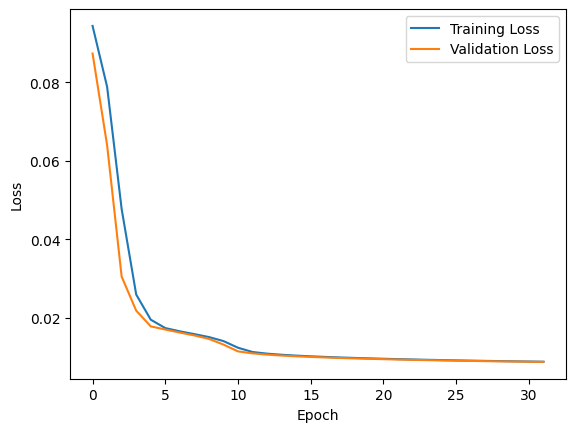

In [5]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

## Visualize Results

1/1 [==============================] - 0s 231ms/step


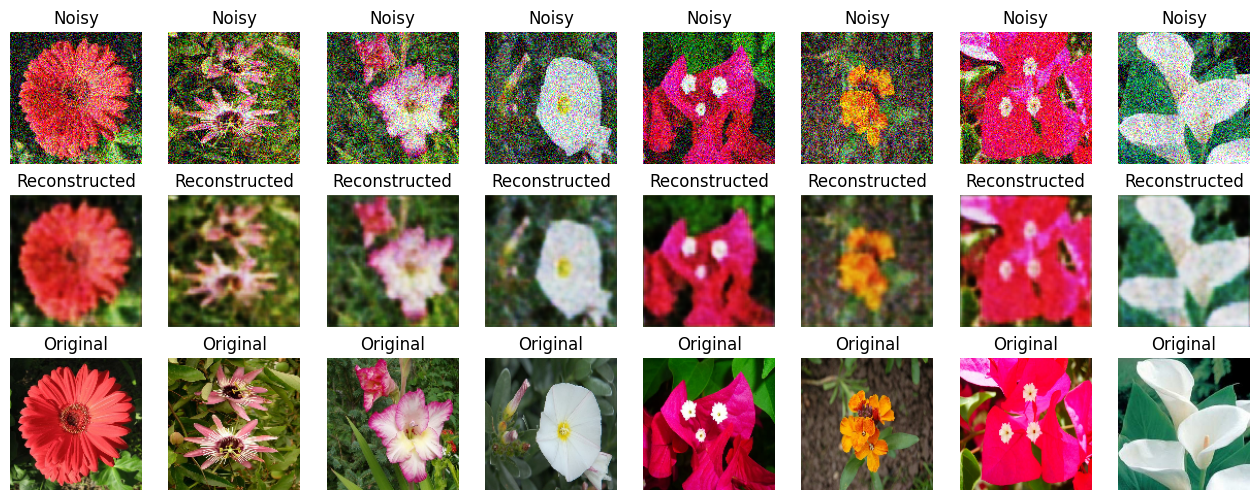

In [6]:
NUMBER_OF_IMAGES = 8
ROWS = 3

autoencoder.load_weights("autoencoder.h5")
noisy_images, original_images = next(iter(test.unbatch().batch(NUMBER_OF_IMAGES)))
reconstructed_images = autoencoder.predict(noisy_images)

plt.figure(figsize=(2 * NUMBER_OF_IMAGES, 2 * ROWS))
for i in range(NUMBER_OF_IMAGES):
    plt.subplot(ROWS, NUMBER_OF_IMAGES, i + 0 * NUMBER_OF_IMAGES + 1)
    plt.imshow(noisy_images[i])
    plt.title("Noisy")
    plt.axis("off")

    plt.subplot(ROWS, NUMBER_OF_IMAGES, i + 1 * NUMBER_OF_IMAGES + 1)
    plt.imshow(reconstructed_images[i])
    plt.title("Reconstructed")
    plt.axis("off")

    plt.subplot(ROWS, NUMBER_OF_IMAGES, i + 2 * NUMBER_OF_IMAGES + 1)
    plt.imshow(original_images[i])
    plt.title("Original")
    plt.axis("off")

plt.show()